# Compare different DEMs for individual glaciers

For most glaciers in the world there are several digital elevation models (DEM) which cover the respective glacier. In OGGM we have currently implemented 10 different open access DEMs to choose from. Some are regional and only available in certain areas (e.g. Greenland or Antarctica) and some cover almost the entire globe. For more information, visit the [rgitools documentation about DEMs](https://rgitools.readthedocs.io/en/latest/dems.html).

This notebook allows to see which of the DEMs are available for a selected glacier and how they compare to each other. That way it is easy to spot systematic differences and also invalid points in the DEMs.

## Input parameters 

This notebook can be run as a script with parameters using [papermill](https://github.com/nteract/papermill), but it is not necessary. The following cell contains the parameters you can choose from:

In [1]:
# The RGI Id of the glaciers you want to look for
# Use the original shapefiles or the GLIMS viewer to check for the ID: https://www.glims.org/maps/glims
rgi_id = 'RGI60-11.00897'

# The default is to test for all sources available for this glacier
# Set to a list of source names to override this
sources = None
# Where to write the plots. Default is in the current working directory
plot_dir = ''
# The RGI version to use
# V62 is an unofficial modification of V6 with only minor, backwards compatible modifications
prepro_rgi_version = 62
# Size of the map around the glacier. Currently only 10 and 40 are available
prepro_border = 10
# Degree of processing level.  Currently only 1 is available.
from_prepro_level = 1

## Check input and set up

In [2]:
# The sources can be given as parameters
if sources is not None and isinstance(sources, str):
    sources = sources.split(',')

In [3]:
# Plotting directory as well
if not plot_dir:
    plot_dir = './' + rgi_id
import os
plot_dir = os.path.abspath(plot_dir)

In [4]:
import pandas as pd
import numpy as np
from oggm import cfg, utils, workflow, tasks, graphics, GlacierDirectory
import xarray as xr
import geopandas as gpd
import salem
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import itertools

from oggm.utils import DEM_SOURCES
from oggm.workflow import init_glacier_directories

In [5]:
# Make sure the plot directory exists
utils.mkdir(plot_dir);
# Use OGGM to download the data
cfg.initialize()
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-DEMS', reset=True)
cfg.PARAMS['use_intersects'] = False

2021-02-03 14:04:22: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-02-03 14:04:22: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2021-02-03 14:04:22: oggm.cfg: Multiprocessing: using all available processors (N=8)
2021-02-03 14:04:22: oggm.utils: Checking the download verification file checksum...
2021-02-03 14:04:23: oggm.cfg: PARAMS['use_intersects'] changed from `True` to `False`.


## Download the data using OGGM utility functions 

Note that you could reach the same goal by downloading the data manually from https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/rgitopo/ 

In [6]:
# URL of the preprocessed GDirs
gdir_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/rgitopo/'
# We use OGGM to download the data
gdir = init_glacier_directories([rgi_id], from_prepro_level=1, prepro_border=10, 
                                 prepro_rgi_version='62', prepro_base_url=gdir_url)[0]

2021-02-03 14:04:23: oggm.workflow: init_glacier_directories from prepro level 1 on 1 glaciers.
2021-02-03 14:04:23: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers
2021-02-03 14:04:23: oggm.utils: Downloading https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/rgitopo/RGI62/b_010/L1/RGI60-11/RGI60-11.00.tar to /home/mowglie/disk/OGGM_INPUT/download_cache/cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/rgitopo/RGI62/b_010/L1/RGI60-11/RGI60-11.00.tar...
 97% of  61.2 MiB |##################### | Elapsed Time: 0:00:03 ETA:   0:00:002021-02-03 14:04:27: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/rgitopo/RGI62/b_010/L1/RGI60-11/RGI60-11.00.tar
100% of  61.2 MiB |######################| Elapsed Time: 0:00:03 Time:  0:00:03


## Read the DEMs and store them all in a dataset 

In [7]:
if sources is None:
    sources = [src for src in os.listdir(gdir.dir) if src in utils.DEM_SOURCES]

In [8]:
print('RGI ID:', rgi_id)
print('Available DEM sources:', sources)
print('Plotting directory:', plot_dir)

RGI ID: RGI60-11.00897
Available DEM sources: ['DEM3', 'ASTER', 'NASADEM', 'COPDEM', 'SRTM', 'TANDEM', 'MAPZEN', 'AW3D30']
Plotting directory: /home/mowglie/disk/Dropbox/HomeDocs/git/tutorials/notebooks/RGI60-11.00897


In [9]:
# We use xarray to store the data
ods = xr.Dataset()
for src in sources:
    demfile = os.path.join(gdir.dir, src) + '/dem.tif'
    with xr.open_rasterio(demfile) as ds:
        data = ds.sel(band=1).load() * 1.
        ods[src] = data.where(data > -100, np.NaN)
    
    sy, sx = np.gradient(ods[src], gdir.grid.dx, gdir.grid.dx)
    ods[src + '_slope'] = ('y', 'x'),  np.arctan(np.sqrt(sy**2 + sx**2))

with xr.open_rasterio(gdir.get_filepath('glacier_mask')) as ds:
    ods['mask'] = ds.sel(band=1).load()

In [10]:
# Decide on the number of plots and figure size
ns = len(sources)
x_size = 12
n_cols = 3
n_rows = -(-ns // n_cols)
y_size = x_size / n_cols * n_rows

## Raw topography data 

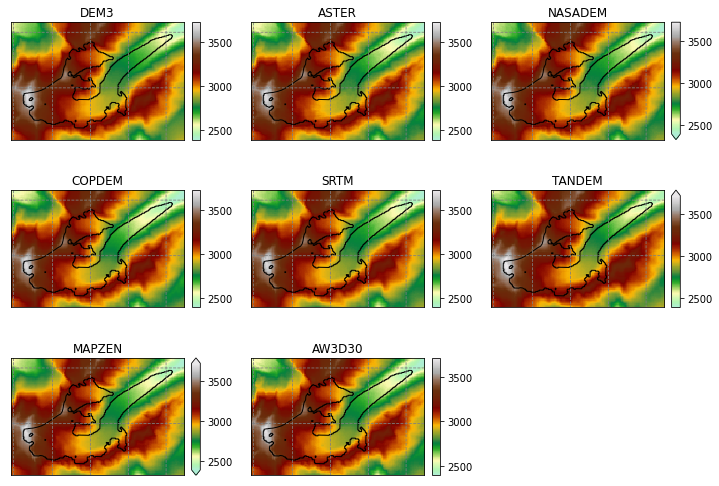

In [11]:
smap = salem.graphics.Map(gdir.grid, countries=False)
smap.set_shapefile(gdir.read_shapefile('outlines'))
smap.set_plot_params(cmap='topo')
smap.set_lonlat_contours(add_tick_labels=False)
smap.set_plot_params(vmin=np.nanquantile([ods[s].min() for s in sources], 0.25),
                     vmax=np.nanquantile([ods[s].max() for s in sources], 0.75))

fig = plt.figure(figsize=(x_size, y_size))
grid = AxesGrid(fig, 111,
                nrows_ncols=(n_rows, n_cols),
                axes_pad=0.7,
                cbar_mode='each',
                cbar_location='right',
                cbar_pad=0.1
                )

for i, s in enumerate(sources):
    data = ods[s]
    smap.set_data(data)
    ax = grid[i]
    smap.visualize(ax=ax, addcbar=False, title=s)
    if np.isnan(data).all():
        grid[i].cax.remove()
        continue
    cax = grid.cbar_axes[i]
    smap.colorbarbase(cax)
    
# take care of uneven grids
if ax != grid[-1]:
    grid[-1].remove()
    grid[-1].cax.remove()

plt.savefig(os.path.join(plot_dir, 'dem_topo_color.png'), dpi=150, bbox_inches='tight')

## Shaded relief 

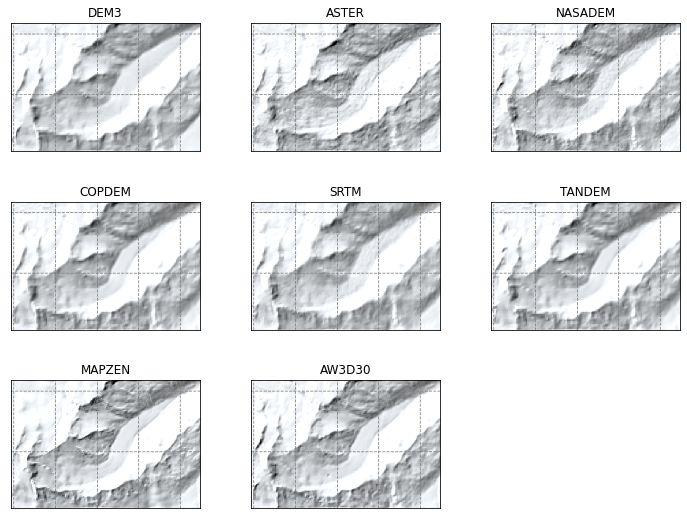

In [12]:
fig = plt.figure(figsize=(x_size, y_size))
grid = AxesGrid(fig, 111,
                nrows_ncols=(n_rows, n_cols),
                axes_pad=0.7,
                cbar_mode='none',
                cbar_location='right',
                cbar_pad=0.1
                )
smap.set_plot_params(cmap='Blues')
smap.set_shapefile()
for i, s in enumerate(sources):
    data = ods[s].copy().where(np.isfinite(ods[s]), 0)
    smap.set_data(data * 0)
    ax = grid[i]
    smap.set_topography(data)
    smap.visualize(ax=ax, addcbar=False, title=s)
    
# take care of uneven grids
if ax != grid[-1]:
    grid[-1].remove()
    grid[-1].cax.remove()

plt.savefig(os.path.join(plot_dir, 'dem_topo_shade.png'), dpi=150, bbox_inches='tight')

## Slope 

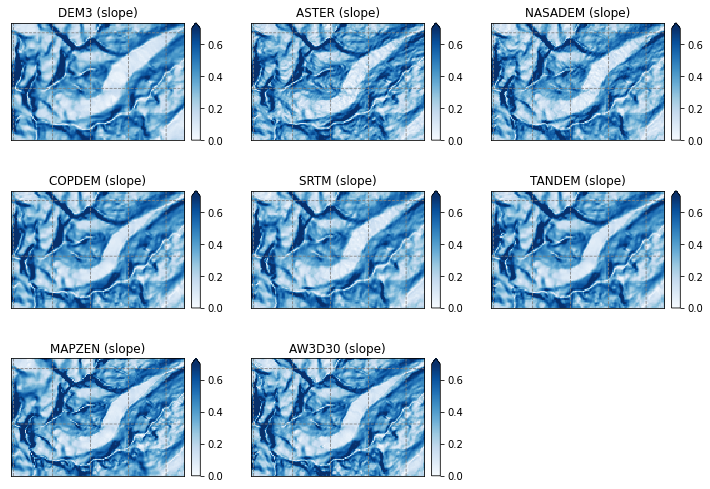

In [13]:
fig = plt.figure(figsize=(x_size, y_size))
grid = AxesGrid(fig, 111,
                nrows_ncols=(n_rows, n_cols),
                axes_pad=0.7,
                cbar_mode='each',
                cbar_location='right',
                cbar_pad=0.1
                )

smap.set_topography();
smap.set_plot_params(vmin=0, vmax=0.7, cmap='Blues')

for i, s in enumerate(sources):
    data = ods[s + '_slope']
    smap.set_data(data)
    ax = grid[i]
    smap.visualize(ax=ax, addcbar=False, title=s + ' (slope)')
    cax = grid.cbar_axes[i]
    smap.colorbarbase(cax)
    
# take care of uneven grids
if ax != grid[-1]:
    grid[-1].remove()
    grid[-1].cax.remove()

plt.savefig(os.path.join(plot_dir, 'dem_slope.png'), dpi=150, bbox_inches='tight')

## Some simple statistics about the DEMs 

In [14]:
df = pd.DataFrame()
for s in sources:
    df[s] = ods[s].data.flatten()[ods.mask.data.flatten() == 1]

dfs = pd.DataFrame()
for s in sources:
    dfs[s] = ods[s + '_slope'].data.flatten()[ods.mask.data.flatten() == 1]

In [15]:
df.describe()

,DEM3,ASTER,NASADEM,COPDEM,SRTM,TANDEM,MAPZEN,AW3D30
count,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000
mean,3061.494096,3031.316346,3028.332505,3014.512451,3032.272219,3066.819092,3023.202610,3023.871970
std,241.860064,250.883864,247.615467,259.186768,246.447678,258.874115,254.144292,253.597569
min,2501.000000,2428.000000,2430.000000,2416.773438,2450.000000,2469.287598,2413.000000,2417.000000
25%,2886.000000,2865.000000,2855.000000,2836.975037,2857.000000,2889.410828,2850.000000,2851.000000
50%,3076.000000,3058.000000,3054.000000,3044.824097,3060.000000,3097.242310,3051.000000,3052.500000
75%,3233.750000,3203.000000,3202.000000,3196.834839,3203.000000,3249.972717,3201.750000,3201.750000
max,3706.000000,3693.000000,3691.000000,3688.330078,3684.000000,3738.977051,3723.000000,3720.000000


## Comparison matrix plot 

In [16]:
# Table of differences between DEMS
df_diff = pd.DataFrame()
done = []
for s1, s2 in itertools.product(sources, sources):
    if s1 == s2:
        continue
    if (s2, s1) in done:
        continue
    df_diff[s1 + '-' + s2] = df[s1] - df[s2]
    done.append((s1, s2))

In [17]:
# Decide on plot levels
max_diff = df_diff.quantile(0.99).max()
base_levels = np.array([-8, -5, -3, -1.5, -1, -0.5, -0.2, -0.1, 0, 0.1, 0.2, 0.5, 1, 1.5, 3, 5, 8])
if max_diff < 10:
    levels = base_levels
elif max_diff < 100:
    levels = base_levels * 10
elif max_diff < 1000:
    levels = base_levels * 100
else:
    levels = base_levels * 1000
levels = [l for l in levels if abs(l) < max_diff]
if max_diff > 10:
    levels = [int(l) for l in levels]
levels

[-100, -50, -20, -10, 0, 10, 20, 50, 100]

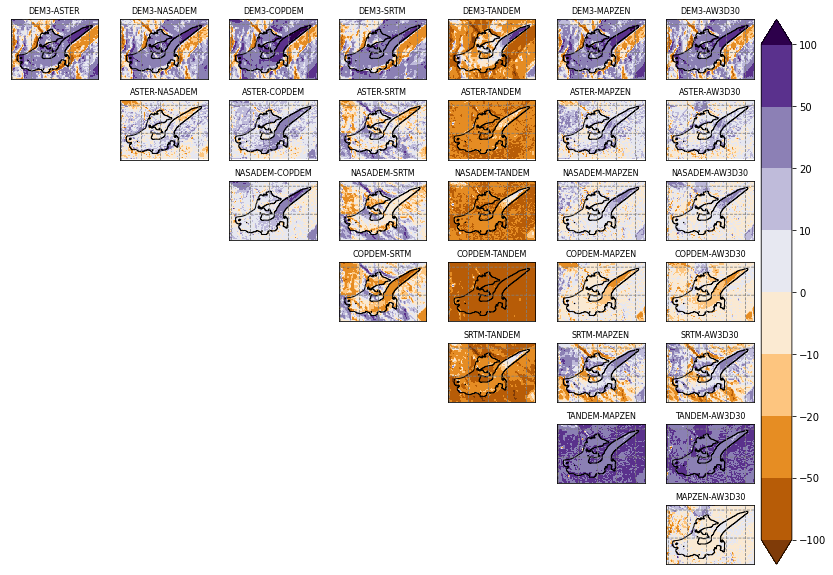

In [18]:
smap.set_plot_params(levels=levels, cmap='PuOr', extend='both')
smap.set_shapefile(gdir.read_shapefile('outlines'))

fig = plt.figure(figsize=(14, 14))
grid = AxesGrid(fig, 111,
                nrows_ncols=(ns - 1, ns - 1),
                axes_pad=0.3,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )
done = []
for ax in grid:
    ax.set_axis_off()
for s1, s2 in itertools.product(sources, sources):
    if s1 == s2:
        continue
    if (s2, s1) in done:
        continue
    data = ods[s1] - ods[s2]
    ax = grid[sources.index(s1) * (ns - 1) + sources[1:].index(s2)]
    ax.set_axis_on()
    smap.set_data(data)
    smap.visualize(ax=ax, addcbar=False)
    done.append((s1, s2))
    ax.set_title(s1 + '-' + s2, fontsize=8)
    
cax = grid.cbar_axes[0]
smap.colorbarbase(cax);

plt.savefig(os.path.join(plot_dir, 'dem_diffs.png'), dpi=150, bbox_inches='tight')

## Comparison scatter plot 

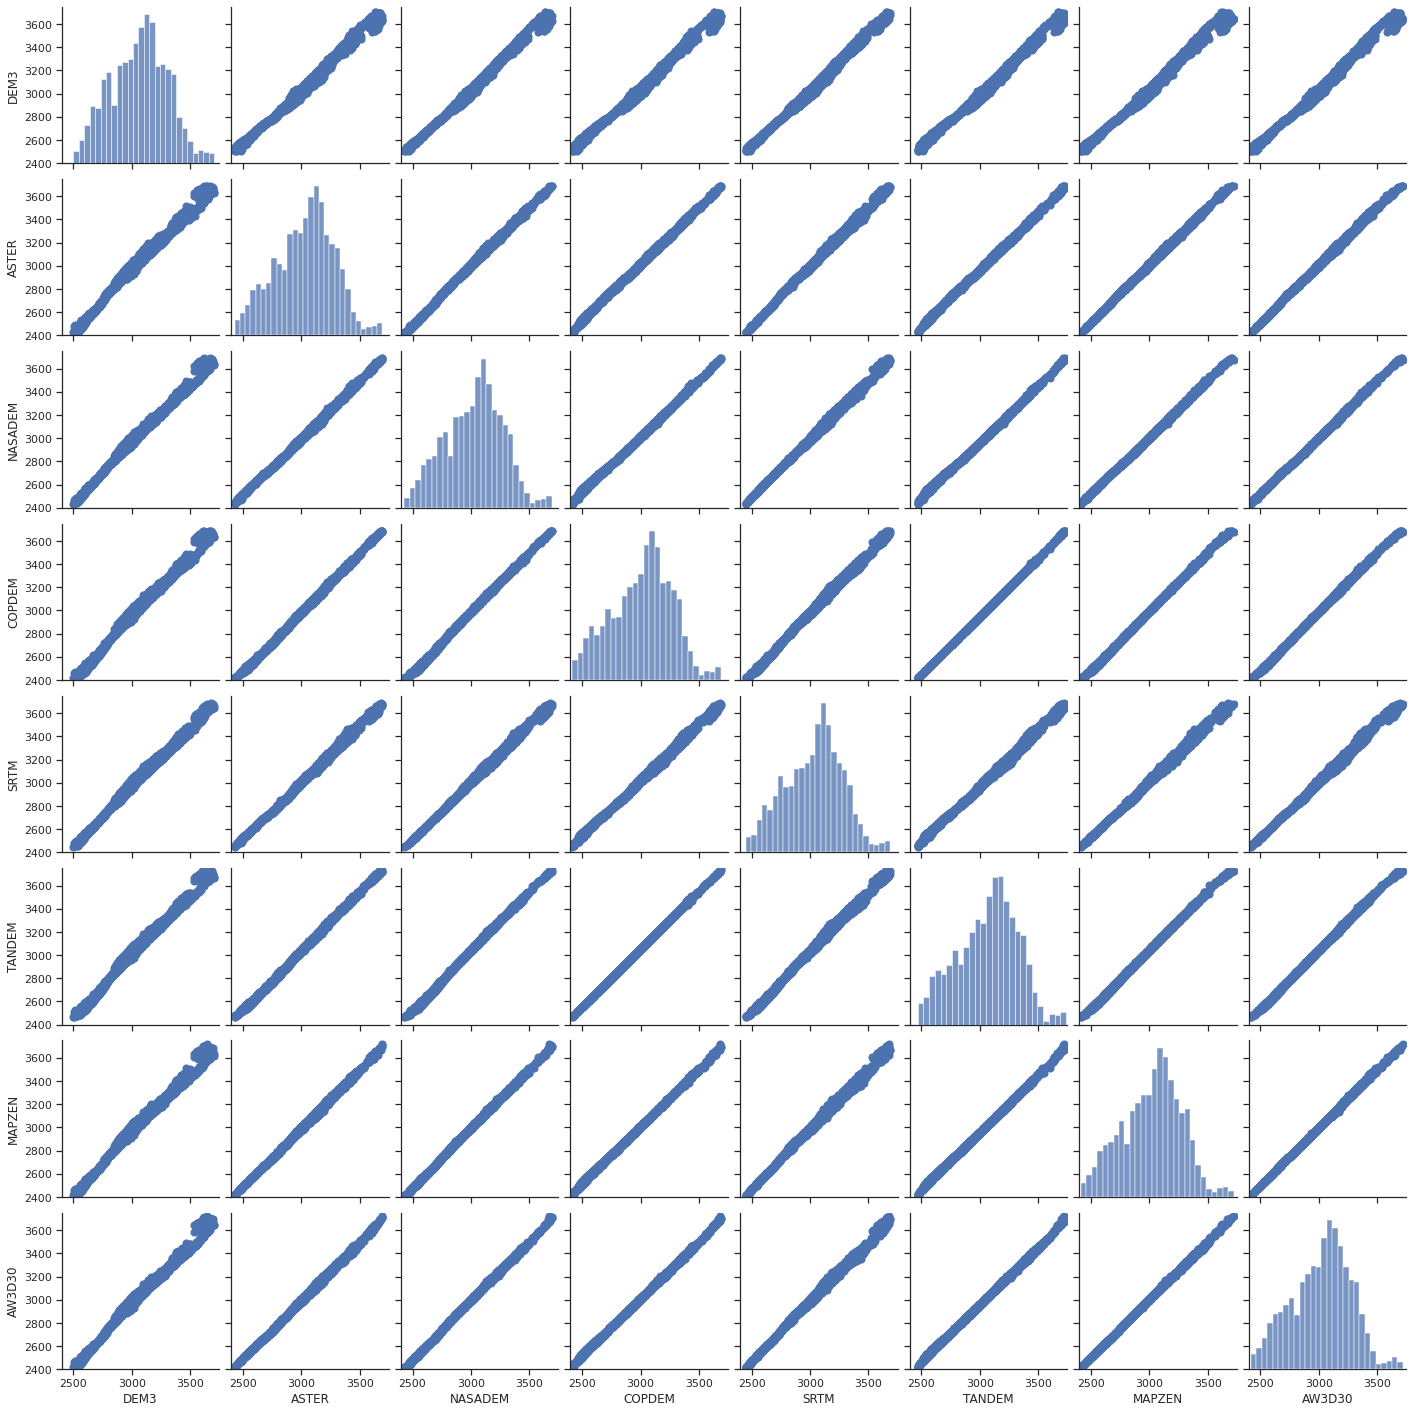

In [19]:
import seaborn as sns
sns.set(style="ticks")

l1, l2 = (utils.nicenumber(df.min().min(), binsize=50, lower=True), 
          utils.nicenumber(df.max().max(), binsize=50, lower=False))

def plot_unity(xdata, ydata, **kwargs):
    points = np.linspace(l1, l2, 100)
    plt.gca().plot(points, points, color='k', marker=None,
                   linestyle=':', linewidth=3.0)

g = sns.pairplot(df.dropna(how='all', axis=1).dropna(), plot_kws=dict(s=50, edgecolor="C0", linewidth=1));
g.map_offdiag(plot_unity)
for asx in g.axes:
    for ax in asx:
        ax.set_xlim((l1, l2))
        ax.set_ylim((l1, l2))

plt.savefig(os.path.join(plot_dir, 'dem_scatter.png'), dpi=150, bbox_inches='tight')

## Table statistics 

In [20]:
df.describe()

,DEM3,ASTER,NASADEM,COPDEM,SRTM,TANDEM,MAPZEN,AW3D30
count,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000
mean,3061.494096,3031.316346,3028.332505,3014.512451,3032.272219,3066.819092,3023.202610,3023.871970
std,241.860064,250.883864,247.615467,259.186768,246.447678,258.874115,254.144292,253.597569
min,2501.000000,2428.000000,2430.000000,2416.773438,2450.000000,2469.287598,2413.000000,2417.000000
25%,2886.000000,2865.000000,2855.000000,2836.975037,2857.000000,2889.410828,2850.000000,2851.000000
50%,3076.000000,3058.000000,3054.000000,3044.824097,3060.000000,3097.242310,3051.000000,3052.500000
75%,3233.750000,3203.000000,3202.000000,3196.834839,3203.000000,3249.972717,3201.750000,3201.750000
max,3706.000000,3693.000000,3691.000000,3688.330078,3684.000000,3738.977051,3723.000000,3720.000000


In [21]:
df.corr()

,DEM3,ASTER,NASADEM,COPDEM,SRTM,TANDEM,MAPZEN,AW3D30
DEM3,1.000000,0.995739,0.997409,0.996189,0.997038,0.996175,0.996358,0.996423
ASTER,0.995739,1.000000,0.999131,0.999365,0.998518,0.999344,0.999455,0.999315
NASADEM,0.997409,0.999131,1.000000,0.999379,0.998544,0.999342,0.999643,0.999553
COPDEM,0.996189,0.999365,0.999379,1.000000,0.998394,0.999974,0.999700,0.999660
SRTM,0.997038,0.998518,0.998544,0.998394,1.000000,0.998315,0.998217,0.998216
TANDEM,0.996175,0.999344,0.999342,0.999974,0.998315,1.000000,0.999687,0.999633
MAPZEN,0.996358,0.999455,0.999643,0.999700,0.998217,0.999687,1.000000,0.999819
AW3D30,0.996423,0.999315,0.999553,0.999660,0.998216,0.999633,0.999819,1.000000


In [22]:
df_diff.describe()

,DEM3-ASTER,DEM3-NASADEM,DEM3-COPDEM,DEM3-SRTM,DEM3-TANDEM,DEM3-MAPZEN,DEM3-AW3D30,ASTER-NASADEM,ASTER-COPDEM,ASTER-SRTM,...,COPDEM-SRTM,COPDEM-TANDEM,COPDEM-MAPZEN,COPDEM-AW3D30,SRTM-TANDEM,SRTM-MAPZEN,SRTM-AW3D30,TANDEM-MAPZEN,TANDEM-AW3D30,MAPZEN-AW3D30
count,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,...,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000
mean,30.177750,33.161591,46.981290,29.221877,-5.325784,38.291485,37.622126,2.983841,16.803539,-0.955873,...,-17.759413,-52.307034,-8.689804,-9.359164,-34.547661,9.069608,8.400249,43.617270,42.947910,-0.669360
std,24.464741,18.533220,27.893263,19.342194,27.721822,24.467068,24.010492,10.892745,12.309234,14.247553,...,19.169901,1.883556,8.057372,8.710851,19.220421,16.809936,16.555147,7.972539,8.722370,4.859039
min,-94.000000,-91.000000,-86.843262,-47.000000,-131.650635,-100.000000,-109.000000,-40.000000,-21.495605,-69.000000,...,-73.730957,-79.299805,-44.972168,-41.972168,-106.757324,-69.000000,-75.000000,1.023926,2.486084,-35.000000
25%,20.000000,25.000000,30.414978,22.000000,-21.998291,25.000000,25.000000,-3.000000,8.315002,-10.000000,...,-29.375549,-52.462891,-11.912292,-14.219543,-45.801941,1.000000,-1.000000,40.532715,38.227905,-3.000000
50%,29.000000,34.000000,45.352905,32.000000,-6.978149,38.000000,36.000000,4.000000,14.929077,0.000000,...,-17.123169,-52.428711,-7.221680,-9.151611,-35.271484,10.000000,9.000000,45.182861,43.253540,-1.000000
75%,42.000000,43.000000,59.555908,40.000000,7.438965,50.000000,49.000000,9.000000,24.004944,7.000000,...,-6.643860,-52.394043,-4.038086,-4.334778,-22.963257,20.750000,20.000000,48.300476,47.949890,1.000000
max,112.000000,92.000000,131.903320,84.000000,79.397461,123.000000,121.000000,55.000000,52.883789,59.000000,...,53.235596,-23.296631,32.682129,29.402100,21.226807,84.000000,79.000000,85.858154,82.822998,28.000000


In [23]:
df_diff.abs().describe()

,DEM3-ASTER,DEM3-NASADEM,DEM3-COPDEM,DEM3-SRTM,DEM3-TANDEM,DEM3-MAPZEN,DEM3-AW3D30,ASTER-NASADEM,ASTER-COPDEM,ASTER-SRTM,...,COPDEM-SRTM,COPDEM-TANDEM,COPDEM-MAPZEN,COPDEM-AW3D30,SRTM-TANDEM,SRTM-MAPZEN,SRTM-AW3D30,TANDEM-MAPZEN,TANDEM-AW3D30,MAPZEN-AW3D30
count,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,...,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000
mean,33.658173,34.688626,48.232542,32.021753,21.395372,40.133623,39.443754,8.758856,17.410436,10.924798,...,21.517830,52.307034,9.364936,10.511262,35.206708,15.292107,14.691734,43.617270,42.947910,3.354257
std,19.397900,15.486716,25.668278,14.233504,18.411083,21.310154,20.882402,7.128573,11.434442,9.193391,...,14.826293,1.883556,7.261413,7.278676,17.984406,11.442731,11.346579,7.972539,8.722370,3.578254
min,0.000000,0.000000,0.087646,0.000000,0.001709,0.000000,0.000000,0.000000,0.000977,0.000000,...,0.012451,23.296631,0.000488,0.000977,0.166016,0.000000,0.000000,1.023926,2.486084,0.000000
25%,21.000000,25.000000,30.705994,24.000000,7.188965,26.000000,26.000000,3.000000,8.656433,4.000000,...,10.496765,52.394043,4.394409,5.184937,22.963257,6.000000,5.000000,40.532715,38.227905,1.000000
50%,30.000000,34.000000,45.544189,32.000000,16.839111,38.000000,36.000000,7.000000,15.060913,9.000000,...,18.754150,52.428711,7.369751,9.402832,35.271484,13.000000,13.000000,45.182861,43.253540,2.000000
75%,43.000000,43.000000,59.782166,41.000000,30.157959,50.000000,49.000000,12.000000,24.004944,16.000000,...,29.730896,52.462891,12.140320,14.364990,45.801941,23.000000,22.000000,48.300476,47.949890,4.000000
max,112.000000,92.000000,131.903320,84.000000,131.650635,123.000000,121.000000,55.000000,52.883789,69.000000,...,73.730957,79.299805,44.972168,41.972168,106.757324,84.000000,79.000000,85.858154,82.822998,35.000000


## What's next?

- return to the [OGGM documentation](https://docs.oggm.org)
- back to the [table of contents](welcome.ipynb)